12.3 实例：TensorFlow实现自编码

我们实现一个只有一个隐含层的自编码器，以MNIST为输入数据，采用keras函数式模型，具体代码如下：

In [1]:
import os
import struct
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.keras.layers import Input,Dense  
from tensorflow.python.keras.models import Model  
from tensorflow.examples.tutorials.mnist import input_data 
%matplotlib inline


Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================]60000/60000 [==============================] - 5s 90us/step - loss: 0.2768 - val_loss: 0.1914

Epoch 2/50
60000/60000 [==============================]60000/60000 [==============================] - 1s 22us/step - loss: 0.1723 - val_loss: 0.1540

Epoch 3/50
60000/60000 [==============================]60000/60000 [==============================] - 1s 24us/step - loss: 0.1444 - val_loss: 0.1335

Epoch 4/50
60000/60000 [==============================]60000/60000 [==============================] - 2s 26us/step - loss: 0.1280 - val_loss: 0.1203

Epoch 5/50
60000/60000 [==============================]60000/60000 [==============================] - 1s 24us/step - loss: 0.1173 - val_loss: 0.1119

Epoch 6/50
60000/60000 [==============================]60000/60000 [==============================] - 1s 24us/step - loss: 0.1104 - val_loss: 0.1063

Epoch 7/50
60000/60000 [==========================

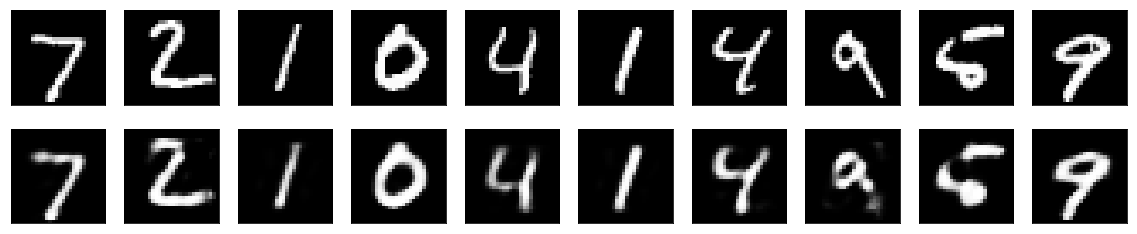

In [2]:
#为避免网络问题，这里我们定义处理本地数据集MNIST的加载函数 
def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,'%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path,'%s-images-idx3-ubyte' % kind)

    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II',lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII",imgpath.read(16))
        images = np.fromfile(imgpath,dtype=np.uint8).reshape(len(labels), 784)

    return images, labels
	
#读取本地训练数据和测试数据 

x_train, y_train = load_mnist('./MNIST_data/', kind='train')
x_test, y_test = load_mnist('./MNIST_data/', kind='t10k')

x_train = x_train.reshape(-1, 28, 28,1).astype('float32')  
x_test = x_test.reshape(-1,28, 28,1).astype('float32')  

#归一化数据，使之在[0,1] 之间
x_train = x_train.astype('float32') / 255.  
x_test = x_test.astype('float32') / 255.  

#对x_train展平为：-1*784
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))  
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))  

#定义输入输入层节点、隐含层节点数  
input_img = Input(shape=(784,))
encoding_dim = 32   

#利用keras函数式模型  
encoded = Dense(encoding_dim, activation='relu')(input_img)  
decoded = Dense(784, activation='sigmoid')(encoded)  

#创建自编码模型
autoencoder = Model(inputs=input_img, outputs=decoded) 

#创建编码器模型 
encoder = Model(inputs=input_img, outputs=encoded)  

encoded_input = Input(shape=(encoding_dim,))  
decoder_layer = autoencoder.layers[-1]  

#创建解码器模型
decoder = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))

#编译自编码器模型  
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')  
#训练该模型  
autoencoder.fit(x_train, x_train, epochs=50, batch_size=256,   
                shuffle=True, validation_data=(x_test, x_test))  
#输出预测值  
encoded_imgs = encoder.predict(x_test)  
decoded_imgs = decoder.predict(encoded_imgs)  

#显示10个数字  
n = 10   
plt.figure(figsize=(20, 4))  
for i in range(n):
    #可视化输入数据  
    ax = plt.subplot(2, n, i + 1)  
    plt.imshow(x_test[i].reshape(28, 28))  
    plt.gray()  
    ax.get_xaxis().set_visible(False)  
    ax.get_yaxis().set_visible(False)  
    #可视化自编码器学习的结果
    ax = plt.subplot(2, n, i + 1 + n)  
    plt.imshow(decoded_imgs[i].reshape(28, 28))  
    plt.gray()  
    ax.get_xaxis().set_visible(False)  
    ax.get_yaxis().set_visible(False)  
plt.show()


12.4实例：用自编码预测信用卡欺诈

这里使用数据源包含两天的284807笔交易记录，其中有492笔交易标注为欺诈。影响欺诈因素包含有28个数值型自变量v1 to v28，这份不是原始数据，而是经过PCA主成分分析后产生的28个主成分变量。另外，有两个变量没有改变，交易Time和交易金额Amount；其中Time是表示该笔交易与前一笔交易的间隔时间（秒）,最后一列为标签class，共31列。
	以下代码使用环境：Python3.6，TensorFlow1.6


1、导入库及数据

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
#为显示中文，导入中文字符集
import matplotlib.font_manager as fm
myfont = fm.FontProperties(fname='/home/wumg/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/simhei.ttf')

import matplotlib.pyplot as plt
%matplotlib inline
#定义文件路径，路径是否正确，然后，查看前5行数据。
try:
    data = pd.read_csv("./creditcard/creditcard.csv")
except Exception as e:
    data = pd.read_csv("creditcard.csv")


2、 查看数据分布

Text(0,0.5,'频度')

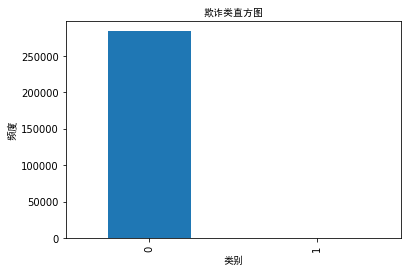

In [4]:
#查看数据集data的大小
data.shape
#查看是否有空值的情况
data.isnull().values.any()
#查看标签数据的分布情况
count_classes = pd.value_counts(data['Class'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("欺诈类直方图",fontproperties=myfont)
plt.xlabel("类别",fontproperties=myfont)
plt.ylabel("频度",fontproperties=myfont)


3、 数据预处理

正规化交易金额数据为另一列，删除原来的Time，Amount两列

In [5]:
from sklearn.preprocessing import StandardScaler

data['normAmount'] = StandardScaler().fit_transform(data['Amount'].reshape(-1, 1))
data = data.drop(['Time','Amount'],axis=1)
data.head()


/home/wumg/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  This is separate from the ipykernel package so we can avoid doing imports until


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,normAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403


4、定义自动编码类

In [6]:
class Autoencoder(object):

    def __init__(self, n_hidden_1, n_hidden_2, n_input, learning_rate):
        self.n_hidden_1 = n_hidden_1
        self.n_hidden_2 = n_hidden_2
        self.n_input = n_input

        self.learning_rate = learning_rate

        self.weights, self.biases = self._initialize_weights()

        self.x = tf.placeholder("float", [None, self.n_input])

        self.encoder_op = self.encoder(self.x)
        self.decoder_op = self.decoder(self.encoder_op)

        self.cost = tf.reduce_mean(tf.pow(self.x - self.decoder_op, 2))
        self.optimizer = tf.train.RMSPropOptimizer(self.learning_rate).minimize(self.cost)

        init = tf.global_variables_initializer()
        self.sess = tf.Session()
        self.sess.run(init)

    def _initialize_weights(self):
        weights = {
            'encoder_h1': tf.Variable(tf.random_normal([self.n_input, self.n_hidden_1])),
            'encoder_h2': tf.Variable(tf.random_normal([self.n_hidden_1, self.n_hidden_2])),
            'decoder_h1': tf.Variable(tf.random_normal([self.n_hidden_2, self.n_hidden_1])),
            'decoder_h2': tf.Variable(tf.random_normal([self.n_hidden_1, self.n_input])),
        }
        biases = {
            'encoder_b1': tf.Variable(tf.random_normal([self.n_hidden_1])),
            'encoder_b2': tf.Variable(tf.random_normal([self.n_hidden_2])),
            'decoder_b1': tf.Variable(tf.random_normal([self.n_hidden_1])),
            'decoder_b2': tf.Variable(tf.random_normal([self.n_input])),
        }

        return weights, biases

    def encoder(self, X):
        layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(X, self.weights['encoder_h1']),
                                       self.biases['encoder_b1']))
        layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, self.weights['encoder_h2']),
                                       self.biases['encoder_b2']))
        return layer_2

    def decoder(self, X):
        layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(X, self.weights['decoder_h1']),
                                       self.biases['decoder_b1']))
        layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, self.weights['decoder_h2']),
                                       self.biases['decoder_b2']))
        return layer_2

    def calc_total_cost(self, X):
        return self.sess.run(self.cost, feed_dict={self.x: X})

    def partial_fit(self, X):
        cost, opt = self.sess.run((self.cost, self.optimizer), feed_dict={self.x: X})
        return cost

    def transform(self, X):
        return self.sess.run(self.encoder_op, feed_dict={self.x: X})

    def reconstruct(self, X):
        return self.sess.run(self.decoder_op, feed_dict={self.x: X})


5、把数据集划分为训练集和测试集

In [7]:
#把标签类型转换为数字型
from sklearn.model_selection import train_test_split
good_data = data[data['Class'] == 0]
bad_data = data[data['Class'] == 1]

#把数据集划分为训练集与测试集（分别为80%，20%）
X_train, X_test = train_test_split(data, test_size=0.2, random_state=42)

X_train = X_train[X_train['Class']==0]
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values

#定义标签
X_good = good_data.loc[:, good_data.columns != 'Class']
y_good = good_data.loc[:, good_data.columns == 'Class']

X_bad = bad_data.loc[:, bad_data.columns != 'Class']
y_bad = bad_data.loc[:, bad_data.columns == 'Class']


6、训练模型

In [8]:
#创建模型
model = Autoencoder(n_hidden_1=15, n_hidden_2=3, n_input=X_train.shape[1], learning_rate = 0.01)

#定义训练步数、批量大小等超参数
training_epochs = 100
batch_size = 256
display_step = 20
record_step = 10

#训练模型
total_batch = int(X_train.shape[0]/batch_size)

cost_summary = []

for epoch in range(training_epochs):
    cost = None
    for i in range(total_batch):
        batch_start = i * batch_size
        batch_end = (i + 1) * batch_size
        batch = X_train[batch_start:batch_end, :]

        cost = model.partial_fit(batch)

    if epoch % display_step == 0 or epoch % record_step == 0:
        total_cost = model.calc_total_cost(X_train)

        if epoch % record_step == 0:
            cost_summary.append({'epoch': epoch+1, 'cost': total_cost})

        if epoch % display_step == 0:
            print("Epoch:{}, cost={:.9f}".format(epoch+1, total_cost))


Epoch:1, cost=0.914110243
Epoch:21, cost=0.880804181
Epoch:41, cost=0.876688540
Epoch:61, cost=0.874031544
Epoch:81, cost=0.873073399


7、查看迭代步数与损失值的关系

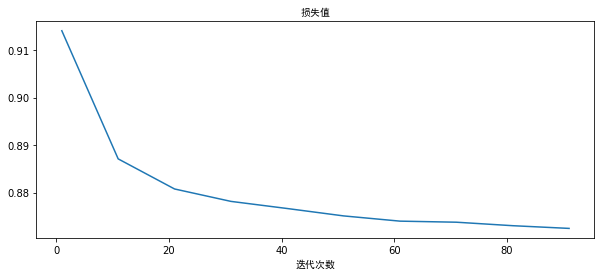

In [9]:
f, ax1 = plt.subplots(1, 1, figsize=(10,4))

ax1.plot(list(map(lambda x: x['epoch'], cost_summary)), list(map(lambda x: x['cost'], cost_summary)))
ax1.set_title('损失值',fontproperties=myfont)

plt.xlabel('迭代次数',fontproperties=myfont)
plt.show()


8、测试模型

In [10]:
#测试模型
encode_decode = None
total_batch = int(X_test.shape[0]/batch_size) + 1
for i in range(total_batch):
    batch_start = i * batch_size
    batch_end = (i + 1) * batch_size
    batch = X_test[batch_start:batch_end, :]
    batch_res = model.reconstruct(batch)
    if encode_decode is None:
        encode_decode = batch_res
    else:
        encode_decode = np.vstack((encode_decode, batch_res))
#获取性能指标
def get_df(orig, ed, _y):
    rmse = np.mean(np.power(orig - ed, 2), axis=1)
    return pd.DataFrame({'rmse': rmse, 'target': _y})

df = get_df(X_test, encode_decode, y_test)
#查看指标的统计信息
df.describe()


,rmse,target
count,56962.000000,56962.000000
mean,0.898791,0.001720
std,3.739196,0.041443
min,0.061990,0.000000
25%,0.300445,0.000000
50%,0.480341,0.000000
75%,0.754466,0.000000
max,260.687466,1.000000


从结果来看，预测指标还不错。